In [1]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os

In [ ]:
from vocal import spectral_masking_vocals

def separatevocals(audiofilepath, outputpath='separated_track/Pop1_vocal.wav'):
    """Robust vocal separation with proper non-negative constraint handling"""
    # Load audio with error handling
    try:
        y, sr = librosa.load(audiofilepath, sr=None)
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None, None, None, None

    # First pass: spectral masking
    try:
        vocals, background = spectral_masking_vocals(y, sr)
    except Exception as e:
        print(f"Spectral masking failed: {e}")
        return None, None, None, None

    # Second pass: NN filter refinement with proper non-negative handling
    try:
        # Compute STFT with safe settings
        S = librosa.stft(vocals, n_fft=2048, hop_length=512)
        S_full, phase = librosa.magphase(S)
        
        # NN filter with absolute values to ensure non-negative
        S_filter = librosa.decompose.nn_filter(np.abs(S_full),
                                              aggregate=np.median,
                                              metric='cosine',
                                              width=int(librosa.time_to_frames(2, sr=sr)))
        S_filter = np.minimum(np.abs(S_full), np.abs(S_filter))

        # Ensure non-negative inputs for softmask
        X = np.abs(S_full) - np.abs(S_filter)
        X_ref = np.abs(S_filter)
        
        # Clip to ensure non-negative (add small epsilon to avoid zeros)
        X = np.clip(X, 1e-10, None)
        X_ref = np.clip(X_ref, 1e-10, None)
        
        # Apply softmask with safe parameters
        mask_v = librosa.util.softmask(X, X_ref * 10, power=1.5)
        
        # Reconstruct audio
        vocals_clean = librosa.istft(mask_v * S_full * phase)
        
        # Post-processing
        vocals_clean = librosa.util.normalize(vocals_clean)
        if len(vocals_clean) > 0:
            vocals_clean = librosa.effects.trim(vocals_clean, top_db=25)[0]
            
    except Exception as e:
        print(f"NN filter processing failed: {e}")
        return None, None, None, None

    # Save output
    try:
        os.makedirs(os.path.dirname(outputpath), exist_ok=True)
        sf.write(outputpath, vocals_clean, sr)
        print(f"Successfully saved vocals to {outputpath}")
    except Exception as e:
        print(f"Error saving output: {e}")
        return None, None, None, None
    
    return y, vocals_clean, background, sr

# Example usage:
original, vocals, background, sr = separatevocals('data/Pop1.wav', 'separated_track/Pop1_vocal.wav')

ParameterError: X and X_ref must be non-negative

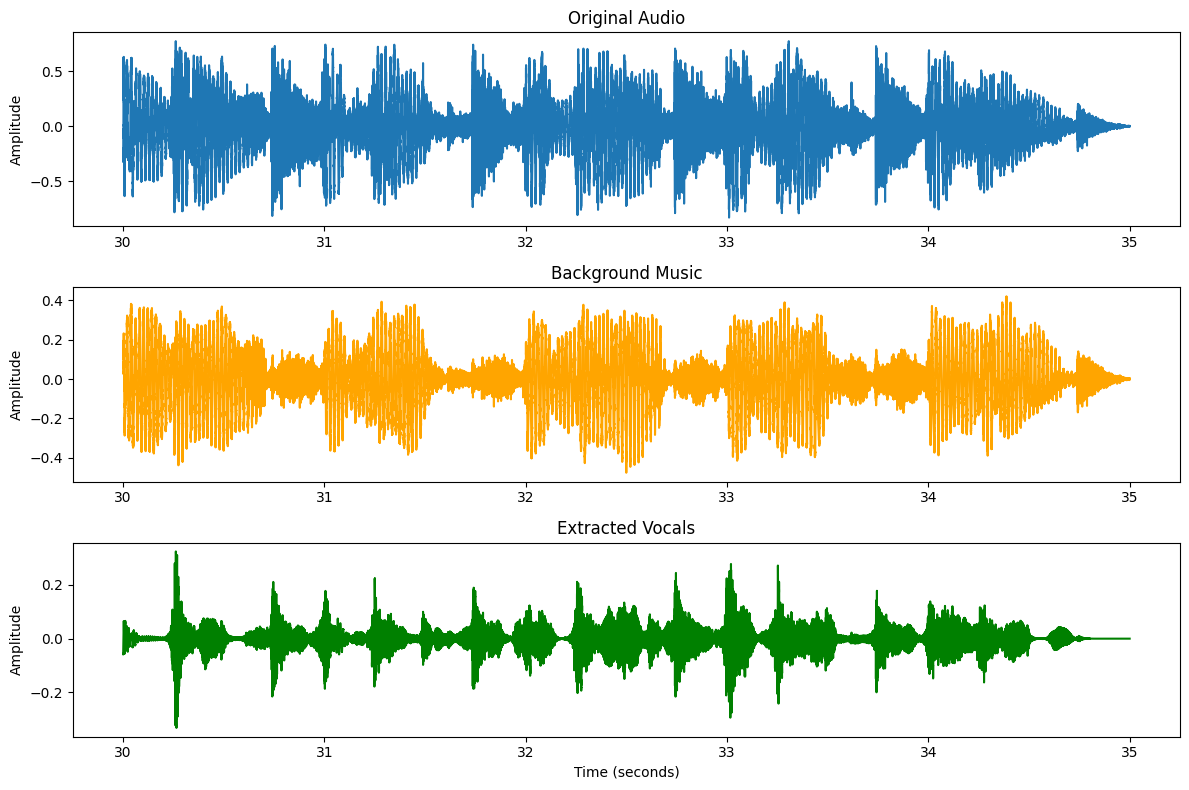

In [10]:
def plot_vocal_separation(original_audio, vocal_audio, background_audio, sr, start_time=30, end_time=35):
    """Visualize the original audio, background music, and extracted vocals"""
    
    # Make all audio arrays the same length by truncating to the shortest one
    min_length = min(len(original_audio), len(vocal_audio), len(background_audio))
    original_audio = original_audio[:min_length]
    vocal_audio = vocal_audio[:min_length]
    background_audio = background_audio[:min_length]
    
    # Convert time to samples
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # Ensure we don't exceed array bounds
    if end_sample > min_length:
        end_sample = min_length
    if start_sample >= end_sample:
        start_sample = max(0, end_sample - int(5 * sr))  # Default to last 5 seconds if range is invalid
    
    # Create time axis for the actual samples we'll plot
    num_samples = end_sample - start_sample
    time = np.linspace(start_time, start_time + num_samples/sr, num_samples)
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time, original_audio[start_sample:end_sample])
    plt.title('Original Audio')
    plt.ylabel('Amplitude')
    
    # Plot background music
    plt.subplot(3, 1, 2)
    plt.plot(time, background_audio[start_sample:end_sample], color='orange')
    plt.title('Background Music')
    plt.ylabel('Amplitude')
    
    # Plot extracted vocals
    plt.subplot(3, 1, 3)
    plt.plot(time, vocal_audio[start_sample:end_sample], color='green')
    plt.title('Extracted Vocals')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()

plot_vocal_separation(original, vocals, background, sr)

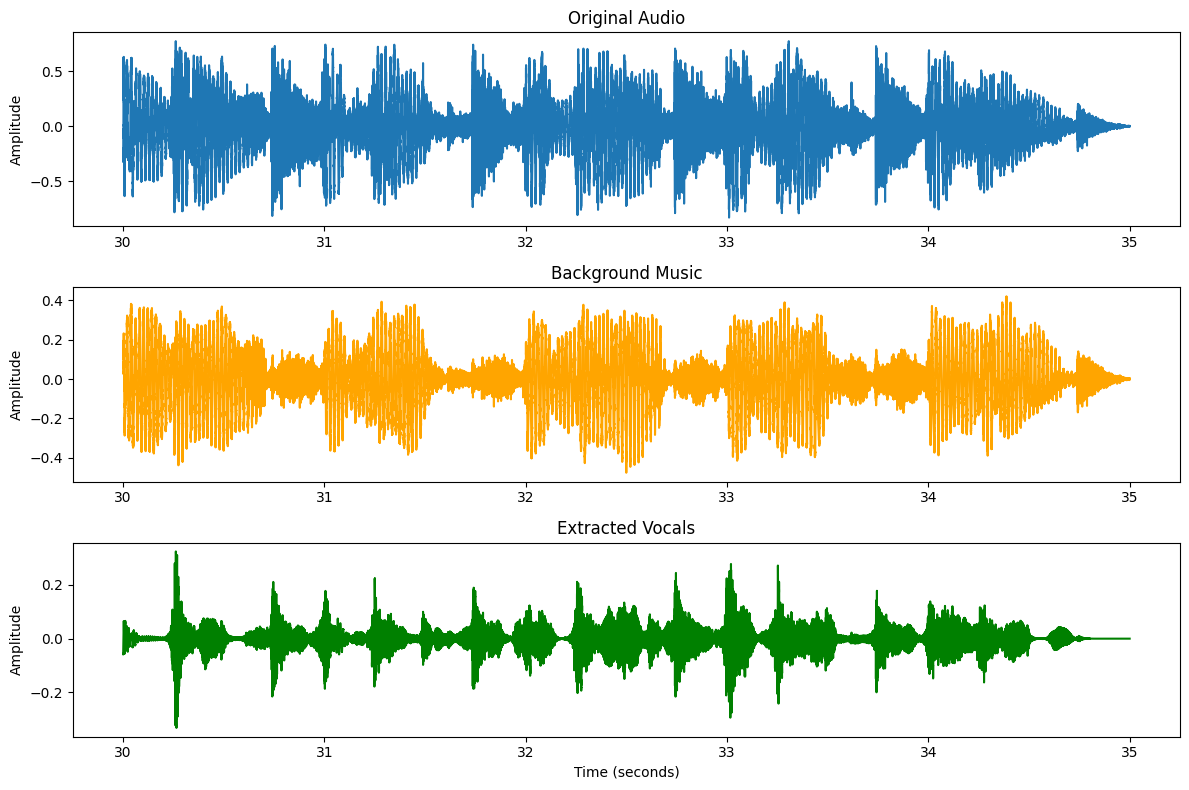

In [12]:
def plot_vocal_separation(original_audio, vocal_audio, background_audio, sr, start_time=30, end_time=35):
    """Visualize the original audio, background music, and extracted vocals"""
    
    # Make all audio arrays the same length by truncating to the shortest one
    min_length = min(len(original_audio), len(vocal_audio), len(background_audio))
    original_audio = original_audio[:min_length]
    vocal_audio = vocal_audio[:min_length]
    background_audio = background_audio[:min_length]
    
    # Convert time to samples
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # Ensure we don't exceed array bounds
    if end_sample > min_length:
        end_sample = min_length
    if start_sample >= end_sample:
        start_sample = max(0, end_sample - int(5 * sr))  # Default to last 5 seconds if range is invalid
    
    # Create time axis for the actual samples we'll plot
    num_samples = end_sample - start_sample
    time = np.linspace(start_time, start_time + num_samples/sr, num_samples)
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time, original_audio[start_sample:end_sample])
    plt.title('Original Audio')
    plt.ylabel('Amplitude')
    
    # Plot background music
    plt.subplot(3, 1, 2)
    plt.plot(time, background_audio[start_sample:end_sample], color='orange')
    plt.title('Background Music')
    plt.ylabel('Amplitude')
    
    # Plot extracted vocals
    plt.subplot(3, 1, 3)
    plt.plot(time, vocal_audio[start_sample:end_sample], color='green')
    plt.title('Extracted Vocals')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()

plot_vocal_separation(original, vocals, background, sr)